# Abalone

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

from pca import pca
import dm_functions as dm
import logistic_regression as logit
import neural_network as nn
import decision_tree as dt
import class_imbalance as balance
import prepare_data as prep
import decision_tree_imbalance as imb_dt

## Download data

In [2]:
df = pd.read_table("./data/abalone19.dat",
                   skiprows =13,
                   header = None,
                   delimiter=",")
df.columns = ["sex", "length", "diameter", "height", "whole_weight", "shucked_weight", "viscera_weight", 
              "shell_weight", "class"]

df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,class
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,negative
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,negative
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,negative
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,negative
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,negative


## Exploratory analysis

Describe numeric variables

In [3]:
df.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
count,4174.000000,4174.000000,4174.000000,4174.000000,4174.000000,4174.000000,4174.000000
mean,0.524032,0.407919,0.139524,0.828771,0.359361,0.180607,0.238853
std,0.120033,0.099187,0.041818,0.490065,0.221771,0.109574,0.139143
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,0.450000,0.350000,0.115000,0.442125,0.186500,0.093500,0.130000
50%,0.545000,0.425000,0.140000,0.799750,0.336000,0.171000,0.234000
75%,0.615000,0.480000,0.165000,1.153000,0.501875,0.252875,0.328875
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000


Describe categorical variables

Observation are approximately equally distributed between threes levels of sex variable.  
There are only 32 observations of the positive class

In [4]:
df['counter'] = 1
most_frequent_level = {}

for col in ["sex", "class"]:
    frequency          = pd.DataFrame(df.groupby(col)['counter'].describe()['count'])
    frequency['share'] = round(frequency['count'] / sum(frequency['count']) * 100,2)
    frequency          = frequency.sort_values(by='count', ascending=False)
    
    most_frequent_level[col] = frequency.index[0]
    
    print(frequency, '\n')
del(frequency)

# remove unnecessary variables
df = df.drop(['counter'], axis=1)

      count  share
sex               
M    1526.0  36.56
I    1341.0  32.13
F    1307.0  31.31 

            count  share
class                   
negative   4142.0  99.23
 positive    32.0   0.77 



**Plot distibution of numerical variables in terms of class variables**

There are no obvious differences between variables that belong to two classes

Several variables (for example height) have strong outliers

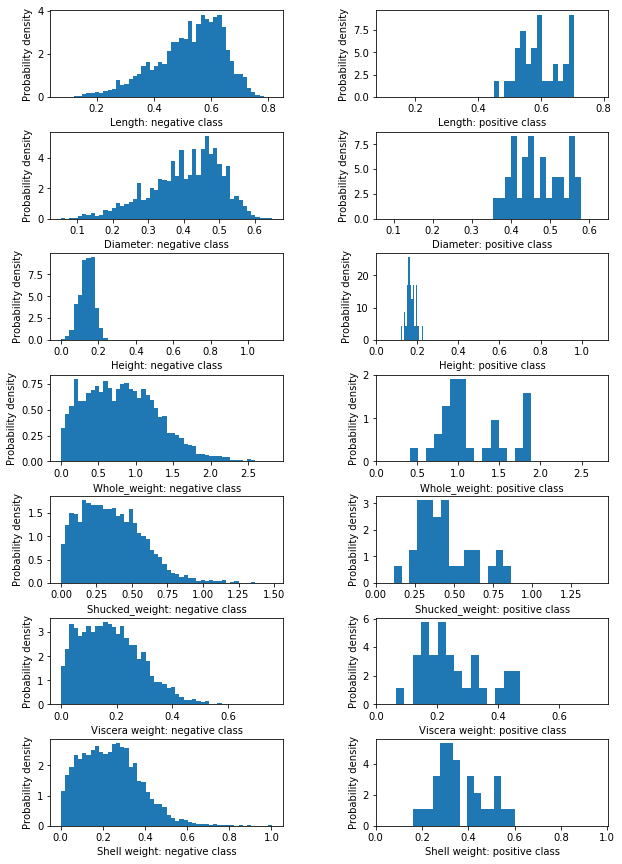

In [5]:
x_labels = ["Length", "Diameter", "Height", "Whole_weight", "Shucked_weight", "Viscera weight", 
            "Shell weight"]

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_size_inches(10.0, 15.0)

counter = 1
for i in range(1, 8):
    
    max_x = max(df.iloc[:,i])
    min_x = min(df.iloc[:,i])
    
    # Graph on the left
    column = df[df["class"]=="negative"].iloc[:,i]
    name   = x_labels[i-1] + ": negative class"

    plt.subplot(7, 2, counter)
    counter += 1
    plt.hist(column, 50, density = True)
    plt.xlabel(name)
    plt.ylabel("Probability density")
    
    
    # Graph on the right
    column = df[df["class"]==" positive"].iloc[:,i]
    name   = x_labels[i-1] + ": positive class"

    plt.subplot(7, 2, counter)
    counter += 1
    plt.hist(column, 15, density = True)
    plt.xlabel(name)
    plt.ylabel("Probability density")    
    
    axes = plt.gca()
    axes.set_xlim([min_x, max_x])
    
    
plt.savefig("abalone_hist.pdf", bbox_inches ="tight")

del(x_labels, axes, fig, max_x, min_x, column, name, counter, i)

**Intersection between class and sex**

Only 2 out of 32 examples of positive class have sex "I".

In [6]:
df['counter'] = 1

group_2 = df.groupby(['class', 'sex'])
group_2 = pd.DataFrame(group_2['counter'].sum())
group_2['share'] = round(group_2['counter'] / np.nansum(group_2['counter'], ) * 100,2)
    
print(group_2, '\n')
del(group_2)
df = df.drop(['counter'], axis=1)

               counter  share
class     sex                
 positive F         15   0.36
          I          2   0.05
          M         15   0.36
negative  F       1292  30.95
          I       1339  32.08
          M       1511  36.20 



### Pre-processing data

**Transform sex and class to dummy variables**

In [7]:
# create dataframe with dummies
var_sex = pd.get_dummies(df[['class', 'sex']])

# remove column with level F and class positive to avoide perfect multicolinearity
var_sex = var_sex.drop(['sex_F', 'class_negative'], axis=1)

# merge datasets
df = pd.concat([var_sex, df], axis=1)

# delete categorical sex and class
df = df.drop(['sex', 'class'], axis=1)

# rename class column to get rid from the space character
df = df.rename(index=str, columns={"class_ positive": "class_positive"})

del(var_sex)
df.head()

,class_positive,sex_I,sex_M,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
0,0,0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,0,0,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,0,0,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,0,0,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,0,1,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


### PCA

In [8]:
# remove class variable
pcaByHandData = df.drop(['class_positive'], axis=1)

# turn dataframe to numpy array
pcaByHandData = pcaByHandData.values

# run pca algorithm
pcaByHandData = pca(pcaByHandData)

# add class variable
y = df['class_positive'].values
y = y.reshape((df.shape[0], 1))

pcaByHandData = np.concatenate((pcaByHandData, y), axis=1)

# change format
pcaByHandData = pd.DataFrame(pcaByHandData)

# change variable type from complex to float
pcaByHandData = pcaByHandData.astype(dtype='float64')

# separate datasets for edible and poisonous mushrooms
df_positive = pcaByHandData[pcaByHandData[pcaByHandData.shape[1]-1]==1]
df_negative = pcaByHandData[pcaByHandData[pcaByHandData.shape[1]-1]==0]

del(y)

Plot results

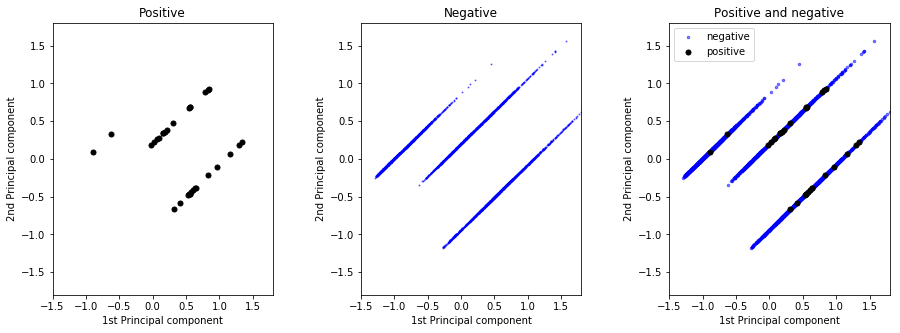

In [9]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_size_inches(15.0, 5.0)

plt.subplot(1, 3, 1)
plt.plot(df_positive[0], df_positive[1], marker='.', linestyle='', ms=10, label='positive', alpha=1, c='black')

plt.xlabel("1st Principal component")
plt.ylabel("2nd Principal component")
plt.title("Positive")

axes = plt.gca()
axes.set_xlim([-1.5, 1.8])
axes.set_ylim([-1.8, 1.8])

#############

plt.subplot(1, 3, 2)
plt.plot(df_negative[0], df_negative[1], marker='.', linestyle='', ms=2, label='negative', alpha=0.5, c='blue')

plt.xlabel("1st Principal component")
plt.ylabel("2nd Principal component")
plt.title("Negative")

axes = plt.gca()
axes.set_xlim([-1.5, 1.8])
axes.set_ylim([-1.8, 1.8])


#############

plt.subplot(1, 3, 3)
plt.plot(df_negative[0], df_negative[1], marker='.', linestyle='', ms=5, label='negative', alpha=0.5, c='blue')
plt.plot(df_positive[0], df_positive[1], marker='.', linestyle='', ms=10, label='positive', c='black')


plt.legend()

plt.xlabel("1st Principal component")
plt.ylabel("2nd Principal component")
plt.title("Positive and negative")

axes = plt.gca()
axes.set_xlim([-1.5, 1.8])
axes.set_ylim([-1.8, 1.8])

del(fig, axes, df_negative, df_positive)

Interestingly data seemes to be divided into three groups. This is likely a consequence of three levels of sex variable (for example two observations with positive class have sex "I" and two positive observations belong to the upper cluster).

Positive observations overlap with other observations. It is not possible to perform classification using first two pca components.

First three PCA components explaint 97% of variance

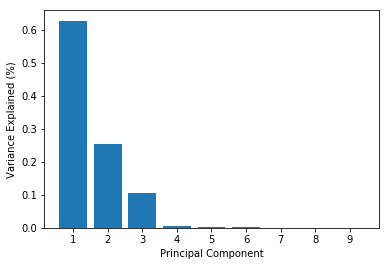

In [10]:
# claculate variance by column
vars = np.var(pcaByHandData.iloc[:,0:9], axis=0) / sum(np.var(pcaByHandData.iloc[:,0:9], axis=0))

plt.figure(figsize =(6 ,4))

plt.bar(range(1,len(vars)+1), vars, tick_label =range(1,len(vars)+1))
plt.xlabel ("Principal Component")
plt.ylabel ("Variance Explained (%)")

plt.savefig ("abalone_vars.pdf")
del(vars)

## Processing data

### Removing outliers

In [11]:
# standardize numeric variables
df_stand = df.iloc[:,3:]

for i in range(df_stand.shape[1]):
    
    df_stand.iloc[:,i] = dm.vector_standard(df_stand.iloc[:,i])
del(i)
round(df_stand.describe(),2)

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
count,4174.00,4174.00,4174.00,4174.00,4174.00,4174.00,4174.00
mean,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.74,-3.56,-3.34,-1.69,-1.62,-1.64,-1.71
25%,-0.62,-0.58,-0.59,-0.79,-0.78,-0.80,-0.78
50%,0.17,0.17,0.01,-0.06,-0.11,-0.09,-0.03
75%,0.76,0.73,0.61,0.66,0.64,0.66,0.65
max,2.42,2.44,23.69,4.07,5.09,5.29,5.51


Height has outliers 24 std away from the mean!

Detect outliers

If we will use 2 std as a cut-off criteria, we will lose 7 positive observations. We cannot afford it. Therefore 2.7 std cut-off criteria will be used.

In [12]:
# create list that has value True if row includes outlier
outliers = np.zeros([df_stand.shape[0], 1])

for i in range(df_stand.shape[1]):
    
    indicator = np.array(abs(df_stand.iloc[:,i])>2.7).reshape(df_stand.shape[0], 1)
    outliers  += indicator
    
outliers = outliers > 0

del(i, indicator)

print(sum(outliers)[0], "outliers detected")
print(sum(df[outliers].iloc[:,0]), "positive observations are outliers")

153 outliers detected
0 positive observations are outliers


In [13]:
df = df[outliers==False]
del(outliers)

### Normalise data

To make machine learning algorithms more efficient, we will normalize data.

In [14]:
# normalize numeric variables
df_norm = df.copy()

for i in range(3, df_norm.shape[1]):
    
    vector = list(df_norm.iloc[:,i])
    vector = dm.vector_normal(vector)
    df_norm.iloc[:,i] = vector

del(i, vector)
round(df_norm.describe(),3)

,class_positive,sex_I,sex_M,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
count,4021.000,4021.000,4021.000,4021.000,4021.000,4021.000,4021.000,4021.000,4021.000,4021.000
mean,0.008,0.323,0.363,0.578,0.577,0.495,0.368,0.359,0.372,0.375
std,0.089,0.468,0.481,0.199,0.204,0.163,0.213,0.213,0.213,0.209
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.446,0.451,0.386,0.196,0.187,0.199,0.205
50%,0.000,0.000,0.000,0.607,0.604,0.500,0.361,0.341,0.356,0.370
75%,0.000,1.000,1.000,0.732,0.736,0.614,0.524,0.510,0.520,0.519
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


### Prepare data for cross-validation

Because we will use cross-validation to deal with class imbalance data, we will firstly randomly shuffle it to assure that observations are in random order.

In [15]:
np.random.seed(15) # set a seed so that the results are consistent

df_norm = df_norm.sample(frac=1)

Next we will divide dataset into two subsets based on the class value

During each step of cross-validation we will use 80% of df_positive and 80% of df_negative as our training set

In [16]:
df_positive = df_norm[df_norm['class_positive']==1]
df_positive = df_positive.reset_index(drop=True)
df_positive['index'] = list(df_positive.index)

df_negative = df_norm[df_norm['class_positive']==0]
df_negative = df_negative.reset_index(drop=True)
df_negative['index'] = list(df_negative.index)

We will perform 9 iterations of cross validations. Lets create two lists that will store beginning and end of test set on each iteration.

In [17]:
start = np.arange(0,   0.9, 0.1)
end   = np.arange(0.2, 1.1, 0.1)

### Functions for running cross-validatio

To avoid unnecessary code repetition we will create two specific functions for handling cross-validation. We will also use functions from class_imbalance and prepare_data.

In [18]:
def run_cross_validation(sampling, inteligent=False):
    '''Runs the cross-validation algorithms'''
    
    # import global variables
    global df_positive
    global df_negative
    global start
    global end
    
    # lists to store accuracy metrics at each run
    logit_train = []
    logit_test  = []

    nn_train = []
    nn_test  = []

    tree_train_res = []
    tree_test_res  = []

    iteration = 0

    # RUN CROSS-VALIDATION
    for i in range(len(start)):
    
        print("Iteration", iteration)
        iteration +=1
    
        pos_length = df_positive.shape[0]
        neg_length = df_negative.shape[0]
        start_iter = start[i]
        end_iter   = end[i]
    
        # create subsets of data
        pos_test, pos_train, neg_test, neg_train = balance.create_sets(pos_length, neg_length, 
                                                                       start_iter, end_iter, 
                                                                       df_positive, df_negative)
        
        # create additional positive points
        if inteligent==True:
            pos_train = balance.intel_sample(pos_train)
        
        
        # create train and test sets
        if sampling=="under":
            train, test = balance.undersample(pos_test, pos_train, neg_test, neg_train)
        else:
            train, test = balance.oversample(pos_test, pos_train, neg_test, neg_train)

        # transform data to format suitable for logit and neural network
        Y_train, X_train, Y_test, X_test = prep.prepare_logit_nn(train, test)
    
        # transform data to format suitable for decision tree
        train_tree, test_tree = prep.prepare_tree(train, test)    
    
    
    
        ###### RUN LOGISTIC REGRESSION
        print("Logistic regression")
        logist_random = logit.model(X_train, Y_train, X_test, Y_test, 
                                    num_iterations=1000, learning_rate=0.5, 
                                    print_cost=False, print_accuracy=False)
    
        logit_train += [logist_random["metrics_train"]]
        logit_test  += [logist_random["metrics_test"]]
    
    
    
        ###### RUN NEURAL NETWORK
        print("Neural network")
        parameters_nn = nn.nn_model(X_train, Y_train, 5, 
                                    num_iterations = 5000, learning_rate = 0.5, 
                                    print_cost=False)

        # Train set
        nn_predict_train = nn.predict_nn(parameters_nn, X_train, Y_train, print_accuracy=False)
        nn_train += [nn_predict_train["metrics"]]


        # Test set
        nn_predict_test = nn.predict_nn(parameters_nn, X_test,  Y_test, print_accuracy=False)
        nn_test  += [nn_predict_test["metrics"]]
    
    
    
        ###### RUN DECISION TREE
        print("Decision tree", "\n")
        Rand_tree = dt.DecisionTree(train_tree, print_accuracy=False)
        tree_rules = Rand_tree.partition(0.9)
    
        # Train set
        res = dt.print_tree_metrics(tree_rules, print_accuracy=False)
        tree_train_res += [res["metrics"]]

        # Test set 
        test_labels = dt.lable_using_tree(test_tree, tree_rules)
        res = dt.eval_tree_test(test_tree, test_labels, print_accuracy=False)
        tree_test_res  += [res["metrics"]]
    
    return logit_train, logit_test, nn_train, nn_test, tree_train_res, tree_test_res

In [19]:
def gather_results(res_train, res_test):
    '''Gathers results from all iterations and all algorithms into two datasets train and test'''
    models = ["logit", "nn", "dt"]
    metric = ["accuracy", "recall", "precision"]

    train = pd.DataFrame({"index": np.arange(len(start))})
    test  = pd.DataFrame({"index": np.arange(len(start))})

    for i in range(len(res_train)):
    
        col_names = []
        for element in metric:
            col_names += [models[i] + "_" + element]
    
        train_group = pd.DataFrame(res_train[i], columns = col_names)
        test_group  = pd.DataFrame(res_test[i], columns = col_names)
    
        train = pd.concat([train, train_group], axis=1)
        test  = pd.concat([test, test_group], axis=1)
        
    return train, test

## CROSS-VALIDATION

- Cross-validation algorithm will use 9 combinations of train/test data.

- We will test undersampling, oversampling, undersampling+inteligent sampling, oversampling+inteligent sampling techniques

- Each time we will run logistic regression, neural network and decision tree algorithms

### Undersampling

In [20]:
logit_train,logit_test,nn_train,nn_test,tree_train_res,tree_test_res = run_cross_validation("under", False)

Iteration 0
Logistic regression
Neural network
Decision tree 

Iteration 1
Logistic regression
Neural network
Decision tree 

Iteration 2
Logistic regression
Neural network
Decision tree 

Iteration 3
Logistic regression
Neural network
Decision tree 

Iteration 4
Logistic regression
Neural network
Decision tree 

Iteration 5
Logistic regression
Neural network
Decision tree 

Iteration 6
Logistic regression
Neural network
Decision tree 

Iteration 7
Logistic regression
Neural network
Decision tree 

Iteration 8
Logistic regression
Neural network
Decision tree 



**Construct dataframes with the results**

In [21]:
res_train = [logit_train, nn_train, tree_train_res]
res_test  = [logit_test,  nn_test,  tree_test_res]

train, test = gather_results(res_train, res_test)

print("Results on training sets:")
train.describe()

Results on training sets:


,index,logit_accuracy,logit_recall,logit_precision,nn_accuracy,nn_recall,nn_precision,dt_accuracy,dt_recall,dt_precision
count,9.000000,9.000000,9.000000,9.000000,9.0,9.0,9.0,9.000000,9.000000,9.000000
mean,4.000000,47.562770,78.962963,79.381271,100.0,100.0,100.0,0.966389,0.981852,0.950741
std,2.738613,6.618025,5.793781,3.982585,0.0,0.0,0.0,0.024502,0.029385,0.026538
min,0.000000,39.454094,68.000000,73.913043,100.0,100.0,100.0,0.920000,0.920000,0.920000
25%,2.000000,41.315136,76.000000,76.923077,100.0,100.0,100.0,0.958333,0.958333,0.920000
50%,4.000000,47.080745,80.000000,80.000000,100.0,100.0,100.0,0.979167,1.000000,0.958333
75%,6.000000,51.364764,83.333333,80.769231,100.0,100.0,100.0,0.980000,1.000000,0.960000
max,8.000000,58.757764,84.000000,86.956522,100.0,100.0,100.0,1.000000,1.000000,1.000000


In [22]:
print("Results on test sets:")
test.describe()

Results on test sets:


,index,logit_accuracy,logit_recall,logit_precision,nn_accuracy,nn_recall,nn_precision,dt_accuracy,dt_recall,dt_precision
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,4.000000,47.562770,46.825397,0.814310,47.040426,42.261905,0.752332,0.724265,0.016263,0.492063
std,2.738613,6.618025,28.316071,0.492123,10.417502,26.274891,0.531393,0.040095,0.005117,0.153642
min,0.000000,39.454094,0.000000,0.000000,28.784119,12.500000,0.207900,0.669565,0.007605,0.285714
25%,2.000000,41.315136,25.000000,0.453515,39.653036,25.000000,0.399202,0.688586,0.014563,0.428571
50%,4.000000,47.080745,57.142857,0.817996,48.198758,28.571429,0.628931,0.734491,0.014634,0.428571
75%,6.000000,51.364764,71.428571,1.265823,53.473945,57.142857,1.063830,0.744417,0.019685,0.625000
max,8.000000,58.757764,85.714286,1.488834,60.124224,85.714286,1.818182,0.791822,0.023041,0.714286


Neither of models has decent recall

### Oversampling

In [629]:
logit_train,logit_test,nn_train,nn_test,tree_train_res,tree_test_res = run_cross_validation("over", False)

Iteration 0
Logistic regression
Neural network
Decision tree 

Iteration 1
Logistic regression
Neural network
Decision tree 

Iteration 2
Logistic regression
Neural network
Decision tree 

Iteration 3
Logistic regression
Neural network
Decision tree 

Iteration 4
Logistic regression
Neural network
Decision tree 

Iteration 5
Logistic regression
Neural network
Decision tree 

Iteration 6
Logistic regression
Neural network
Decision tree 

Iteration 7
Logistic regression
Neural network
Decision tree 

Iteration 8
Logistic regression
Neural network
Decision tree 



**Construct dataframes with the results**

In [630]:
res_train = [logit_train, nn_train, tree_train_res]
res_test  = [logit_test,  nn_test,  tree_test_res]

train, test = gather_results(res_train, res_test)

print("Results on training sets:")
train.describe()

Results on training sets:


,index,logit_accuracy,logit_recall,logit_precision,nn_accuracy,nn_recall,nn_precision,dt_accuracy,dt_recall,dt_precision
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,4.000000,54.908530,61.176534,59.324179,60.453830,66.564354,59.308149,0.944013,0.921674,0.970569
std,2.738613,1.736117,1.528538,0.919262,1.776521,6.770522,1.258014,0.008571,0.007004,0.017283
min,0.000000,52.416357,59.122257,58.051629,57.442808,58.947039,57.225434,0.930408,0.910586,0.954545
25%,2.000000,53.598015,60.219436,58.764148,59.545455,61.692790,58.570689,0.939987,0.918854,0.965204
50%,4.000000,55.652174,61.034483,59.160539,60.376176,63.354232,59.232122,0.942006,0.919597,0.965204
75%,6.000000,56.079404,62.445141,59.915357,61.567398,70.909091,60.039960,0.947962,0.922409,0.965215
max,8.000000,57.515528,63.385580,60.638298,63.083673,78.439361,61.175045,0.957367,0.933030,1.000000


In [631]:
print("Results on test sets:")
test.describe()

Results on test sets:


,index,logit_accuracy,logit_recall,logit_precision,nn_accuracy,nn_recall,nn_precision,dt_accuracy,dt_recall,dt_precision
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,4.000000,54.908530,27.579365,0.558296,54.081039,24.801587,0.492952,0.907085,0.021243,0.214286
std,2.738613,1.736117,24.437406,0.495400,4.796200,22.418440,0.437567,0.011960,0.015072,0.154905
min,0.000000,52.416357,0.000000,0.000000,46.096654,0.000000,0.000000,0.892060,0.000000,0.000000
25%,2.000000,53.598015,0.000000,0.000000,51.304348,12.500000,0.233100,0.900621,0.013333,0.125000
50%,4.000000,55.652174,28.571429,0.539084,54.094293,25.000000,0.491400,0.904585,0.023810,0.285714
75%,6.000000,56.079404,42.857143,0.842697,57.620818,28.571429,0.636943,0.918114,0.033333,0.285714
max,8.000000,57.515528,71.428571,1.449275,60.669975,71.428571,1.408451,0.924318,0.040000,0.428571


For logit and neural network recall is even worth

### Inteligent undersampling

In [637]:
logit_train,logit_test,nn_train,nn_test,tree_train_res,tree_test_res = run_cross_validation("under", True)

Iteration 0
Logistic regression
Neural network
Decision tree 



C:\Users\Oleksa\Documents\Term_1\Data_Mining\Coursework\decision_tree.py:43: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (v_ones/v_length)**2 - ((v_length-v_ones)/v_length)**2
C:\Users\Oleksa\Documents\Term_1\Data_Mining\Coursework\decision_tree.py:43: RuntimeWarning: invalid value encountered in long_scalars
  return 1 - (v_ones/v_length)**2 - ((v_length-v_ones)/v_length)**2


Iteration 1
Logistic regression
Neural network
Decision tree 

Iteration 2
Logistic regression
Neural network
Decision tree 

Iteration 3
Logistic regression
Neural network
Decision tree 

Iteration 4
Logistic regression
Neural network
Decision tree 

Iteration 5
Logistic regression
Neural network
Decision tree 

Iteration 6
Logistic regression
Neural network
Decision tree 

Iteration 7
Logistic regression
Neural network
Decision tree 

Iteration 8
Logistic regression
Neural network
Decision tree 



**Construct dataframes with the results**

In [638]:
res_train = [logit_train, nn_train, tree_train_res]
res_test  = [logit_test,  nn_test,  tree_test_res]

train, test = gather_results(res_train, res_test)

print("Results on training sets:")
train.describe()

Results on training sets:


,index,logit_accuracy,logit_recall,logit_precision,nn_accuracy,nn_recall,nn_precision,dt_accuracy,dt_recall,dt_precision
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,4.000000,60.658622,60.250712,61.087333,71.621083,73.413105,71.324880,0.939516,0.921191,0.961368
std,2.738613,6.225432,2.724797,2.096745,3.445369,6.318269,4.841742,0.008682,0.010325,0.011697
min,0.000000,48.946716,56.307692,57.366771,65.538462,67.692308,62.287105,0.923077,0.904624,0.938462
25%,2.000000,58.881988,58.461538,59.936909,69.692308,68.000000,67.791411,0.936923,0.916667,0.960000
50%,4.000000,61.662531,60.615385,61.056106,72.833333,72.923077,71.477663,0.940000,0.920354,0.960000
75%,6.000000,66.501241,62.461538,61.409396,73.692308,75.384615,75.276753,0.944615,0.928571,0.966667
max,8.000000,66.997519,63.666667,64.093960,75.692308,86.769231,76.948052,0.952308,0.937500,0.981538


In [639]:
print("Results on test sets:")
test.describe()

Results on test sets:


,index,logit_accuracy,logit_recall,logit_precision,nn_accuracy,nn_recall,nn_precision,dt_accuracy,dt_recall,dt_precision
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,4.000000,60.658622,27.777778,0.631649,61.843170,32.142857,0.832793,0.818442,0.023811,0.494048
std,2.738613,6.225432,21.206271,0.465014,8.190237,18.449981,0.535468,0.028591,0.012059,0.265165
min,0.000000,48.946716,0.000000,0.000000,52.357320,12.500000,0.263852,0.775434,0.007042,0.142857
25%,2.000000,58.881988,14.285714,0.328947,56.505576,14.285714,0.289855,0.800000,0.015152,0.250000
50%,4.000000,61.662531,28.571429,0.643087,61.414392,28.571429,0.649351,0.812655,0.026316,0.571429
75%,6.000000,66.501241,37.500000,0.800000,62.903226,42.857143,1.333333,0.831475,0.031847,0.714286
max,8.000000,66.997519,71.428571,1.497006,76.674938,62.500000,1.650165,0.864764,0.042373,0.857143


### Inteligent oversampling

In [640]:
logit_train,logit_test,nn_train,nn_test,tree_train_res,tree_test_res = run_cross_validation("over", True)

Iteration 0
Logistic regression
Neural network
Decision tree 



C:\Users\Oleksa\Documents\Term_1\Data_Mining\Coursework\decision_tree.py:43: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (v_ones/v_length)**2 - ((v_length-v_ones)/v_length)**2
C:\Users\Oleksa\Documents\Term_1\Data_Mining\Coursework\decision_tree.py:43: RuntimeWarning: invalid value encountered in long_scalars
  return 1 - (v_ones/v_length)**2 - ((v_length-v_ones)/v_length)**2


Iteration 1
Logistic regression
Neural network
Decision tree 

Iteration 2
Logistic regression
Neural network
Decision tree 

Iteration 3
Logistic regression
Neural network
Decision tree 

Iteration 4
Logistic regression
Neural network
Decision tree 

Iteration 5
Logistic regression
Neural network
Decision tree 

Iteration 6
Logistic regression
Neural network
Decision tree 

Iteration 7
Logistic regression
Neural network
Decision tree 

Iteration 8
Logistic regression
Neural network
Decision tree 



**Construct dataframes with the results**

In [641]:
res_train = [logit_train, nn_train, tree_train_res]
res_test  = [logit_test,  nn_test,  tree_test_res]

train, test = gather_results(res_train, res_test)

print("Results on training sets:")
train.describe()

Results on training sets:


,index,logit_accuracy,logit_recall,logit_precision,nn_accuracy,nn_recall,nn_precision,dt_accuracy,dt_recall,dt_precision
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,4.000000,56.630847,66.264879,61.346548,62.513855,72.004949,60.618621,0.922732,0.898372,0.953363
std,2.738613,1.508390,1.884690,1.158722,2.885834,5.548608,2.748628,0.011133,0.008647,0.020268
min,0.000000,54.714640,62.633229,59.517426,58.432602,66.718897,56.701545,0.903762,0.882423,0.931661
25%,2.000000,54.838710,65.454545,60.506621,60.419931,68.996865,59.254105,0.915674,0.895021,0.935110
50%,4.000000,57.391304,66.081505,61.547445,62.852665,71.200251,60.814136,0.921003,0.897230,0.945455
75%,6.000000,57.868649,67.241379,61.842105,65.156740,72.695925,62.200404,0.932466,0.903757,0.964263
max,8.000000,58.188586,69.445315,63.278127,66.797242,85.235110,65.437788,0.937931,0.909982,0.985898


In [642]:
print("Results on test sets:")
test.describe()

Results on test sets:


,index,logit_accuracy,logit_recall,logit_precision,nn_accuracy,nn_recall,nn_precision,dt_accuracy,dt_recall,dt_precision
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,4.000000,56.630847,24.603175,0.523681,54.620318,21.230159,0.457823,0.881169,0.036845,0.490079
std,2.738613,1.508390,25.234515,0.526783,6.008577,18.264210,0.406725,0.012281,0.018992,0.249858
min,0.000000,54.714640,0.000000,0.000000,47.335812,0.000000,0.000000,0.863524,0.011236,0.142857
25%,2.000000,54.838710,0.000000,0.000000,49.379653,0.000000,0.000000,0.872367,0.020833,0.285714
50%,4.000000,57.391304,14.285714,0.296736,56.381660,25.000000,0.475059,0.877171,0.038095,0.571429
75%,6.000000,57.868649,42.857143,0.887574,58.757764,37.500000,0.857143,0.890954,0.055556,0.625000
max,8.000000,58.188586,71.428571,1.470588,62.903226,42.857143,0.952381,0.901985,0.060976,0.857143


## Alternative decision tree

To maximise recall we constructed an alternative decision tree that choses partitions with the highest share of positive class.

We will use undersampling without 'inteligent' option. This combination seems to work the best.

In [657]:
# lists to store accuracy metrics at each run
tree_train_res = []
tree_test_res  = []

iteration = 0

# RUN CROSS-VALIDATION
for i in range(len(start)):
    
    print("Iteration", iteration)
    iteration +=1
    
    pos_length = df_positive.shape[0]
    neg_length = df_negative.shape[0]
    start_iter = start[i]
    end_iter   = end[i]
    
    # create subsets of data
    pos_test, pos_train, neg_test, neg_train = balance.create_sets(pos_length, neg_length, 
                                                                       start_iter, end_iter, 
                                                                       df_positive, df_negative)
        
    train, test = balance.undersample(pos_test, pos_train, neg_test, neg_train)

    # transform data to format suitable for decision tree
    train_tree, test_tree = prep.prepare_tree(train, test)    
    
    ###### RUN DECISION TREE
    Rand_tree = imb_dt.DecisionTree(train_tree, print_accuracy=True)
    tree_rules = Rand_tree.partition(0.9)
    
    # Train set
    res = imb_dt.print_tree_metrics(tree_rules, print_accuracy=True)
    tree_train_res += [res["metrics"]]

    # Test set 
    test_labels = imb_dt.lable_using_tree(test_tree, tree_rules)
    res = imb_dt.eval_tree_test(test_tree, test_labels, print_accuracy=True)
    tree_test_res  += [res["metrics"]]

Iteration 0
Tree node: c
Level: 0
Number of elements: 6382
Majority class: 1
Accuracy: 0.5


Gini: 0.3579138076737055
Partition column: 9
Partition midpoint: 0.4196354598177299
####### 
 

Tree node: cl
Level: 1
Number of elements: 2118
Majority class: 0
Accuracy: 0.8782


Gini: 0.16875995935923305
Partition column: 5
Partition midpoint: 0.5568181818181819
####### 
 

Tree node: cll
Level: 2
Number of elements: 1820
Majority class: 0
Accuracy: 0.939
Terminal node!
####### 
 

Tree node: clr
Level: 2
Number of elements: 298
Majority class: 0
Accuracy: 0.5067


Gini: 0.0913497390007457
Partition column: 4
Partition midpoint: 0.5219780219780221
####### 
 

Tree node: clrl
Level: 3
Number of elements: 162
Majority class: 1
Accuracy: 0.9074
Terminal node!
####### 
 

Tree node: clrr
Level: 3
Number of elements: 136
Majority class: 0
Accuracy: 1.0
Terminal node!
####### 
 

Tree node: cr
Level: 1
Number of elements: 4264
Majority class: 1
Accuracy: 0.6879


Gini: 0.40849397752398103
Partitio



Gini: 0.4548572038001937
Partition column: 8
Partition midpoint: 0.38930084745762716
####### 
 

Tree node: crlrl
Level: 4
Number of elements: 446
Majority class: 1
Accuracy: 0.8543


Gini: 0.09326909167788668
Partition column: 5
Partition midpoint: 0.5795454545454546
####### 
 

Tree node: crlrll
Level: 5
Number of elements: 43
Majority class: 0
Accuracy: 1.0
Terminal node!
####### 
 

Tree node: crlrlr
Level: 5
Number of elements: 403
Majority class: 1
Accuracy: 0.9454
Terminal node!
####### 
 

Tree node: crlrr
Level: 4
Number of elements: 2036
Majority class: 0
Accuracy: 0.5049


Gini: 0.4142176396102204
Partition column: 9
Partition midpoint: 0.6677713338856668
####### 
 

Tree node: crlrrl
Level: 5
Number of elements: 1208
Majority class: 0
Accuracy: 0.6763


Gini: 0.343433366955911
Partition column: 9
Partition midpoint: 0.42129246064623027
####### 
 

Tree node: crlrrll
Level: 6
Number of elements: 131
Majority class: 1
Accuracy: 0.9466
Terminal node!
####### 
 

Tree node: c

####### 
 

Tree node: crrlrllrlrr
Level: 10
Number of elements: 88
Majority class: 0
Accuracy: 1.0
Terminal node!
####### 
 

Tree node: crrlrllrr
Level: 8
Number of elements: 137
Majority class: 1
Accuracy: 1.0
Terminal node!
####### 
 

Tree node: crrlrlr
Level: 6
Number of elements: 912
Majority class: 0
Accuracy: 0.8542


Gini: 0.15603146853146851
Partition column: 6
Partition midpoint: 0.680970595266555
####### 
 

Tree node: crrlrlrl
Level: 7
Number of elements: 626
Majority class: 0
Accuracy: 1.0
Terminal node!
####### 
 

Tree node: crrlrlrr
Level: 7
Number of elements: 286
Majority class: 0
Accuracy: 0.535


Gini: 0.0
Partition column: 6
Partition midpoint: 0.6812096581400908
####### 
 

Tree node: crrlrlrrl
Level: 8
Number of elements: 133
Majority class: 1
Accuracy: 1.0
Terminal node!
####### 
 

Tree node: crrlrlrrr
Level: 8
Number of elements: 153
Majority class: 0
Accuracy: 1.0
Terminal node!
####### 
 

Tree node: crrlrr
Level: 5
Number of elements: 146
Majority class: 



Gini: 0.4306754728804895
Partition column: 4
Partition midpoint: 0.7747252747252747
####### 
 

Tree node: crrllll
Level: 6
Number of elements: 725
Majority class: 1
Accuracy: 0.5766


Gini: 0.2538548636129697
Partition column: 9
Partition midpoint: 0.45981772990886494
####### 
 

Tree node: crrlllll
Level: 7
Number of elements: 189
Majority class: 0
Accuracy: 1.0
Terminal node!
####### 
 

Tree node: crrllllr
Level: 7
Number of elements: 536
Majority class: 1
Accuracy: 0.7799


Gini: 0.31841074879698555
Partition column: 9
Partition midpoint: 0.46230323115161553
####### 
 

Tree node: crrllllrl
Level: 8
Number of elements: 143
Majority class: 1
Accuracy: 0.965
Terminal node!
####### 
 

Tree node: crrllllrr
Level: 8
Number of elements: 393
Majority class: 1
Accuracy: 0.7125


Gini: 0.13789706968726922
Partition column: 8
Partition midpoint: 0.3707627118644068
####### 
 

Tree node: crrllllrrl
Level: 9
Number of elements: 310
Majority class: 1
Accuracy: 0.9032
Terminal node!
####### 



Gini: 0.19374190158198623
Partition column: 9
Partition midpoint: 0.6835128417564208
####### 
 

Tree node: crlrrll
Level: 6
Number of elements: 623
Majority class: 0
Accuracy: 1.0
Terminal node!
####### 
 

Tree node: crlrrlr
Level: 6
Number of elements: 531
Majority class: 1
Accuracy: 0.6987


Gini: 0.14513678502870353
Partition column: 9
Partition midpoint: 0.7104391052195524
####### 
 

Tree node: crlrrlrl
Level: 7
Number of elements: 414
Majority class: 1
Accuracy: 0.8961


Gini: 0.10462492949802597
Partition column: 3
Partition midpoint: 0.8258928571428571
####### 
 

Tree node: crlrrlrll
Level: 8
Number of elements: 394
Majority class: 1
Accuracy: 0.9416
Terminal node!
####### 
 

Tree node: crlrrlrlr
Level: 8
Number of elements: 20
Majority class: 0
Accuracy: 1.0
Terminal node!
####### 
 

Tree node: crlrrlrr
Level: 7
Number of elements: 117
Majority class: 0
Accuracy: 1.0
Terminal node!
####### 
 

Tree node: crlrrr
Level: 5
Number of elements: 153
Majority class: 1
Accuracy



Gini: 0.39551826139324564
Partition column: 9
Partition midpoint: 0.8409279204639603
####### 
 

Tree node: crl
Level: 2
Number of elements: 3484
Majority class: 1
Accuracy: 0.665


Gini: 0.38834441597724223
Partition column: 4
Partition midpoint: 0.686813186813187
####### 
 

Tree node: crll
Level: 3
Number of elements: 1760
Majority class: 1
Accuracy: 0.8324


Gini: 0.23868715564738294
Partition column: 9
Partition midpoint: 0.4610604805302402
####### 
 

Tree node: crlll
Level: 4
Number of elements: 440
Majority class: 1
Accuracy: 0.5864


Gini: 0.0998065764023211
Partition column: 7
Partition midpoint: 0.27029177718832886
####### 
 

Tree node: crllll
Level: 5
Number of elements: 282
Majority class: 1
Accuracy: 0.9149
Terminal node!
####### 
 

Tree node: crlllr
Level: 5
Number of elements: 158
Majority class: 0
Accuracy: 1.0
Terminal node!
####### 
 

Tree node: crllr
Level: 4
Number of elements: 1320
Majority class: 1
Accuracy: 0.9144
Terminal node!
####### 
 

Tree node: crlr


In [658]:
metric = ["accuracy", "recall", "precision"]

train = pd.DataFrame({"index": np.arange(len(start))})
test  = pd.DataFrame({"index": np.arange(len(start))})

col_names = []
for element in metric:
    col_names += ["imb_dt" + "_" + element]
    
train = pd.DataFrame(tree_train_res, columns = col_names)
test  = pd.DataFrame(tree_test_res, columns = col_names)
    
print("Results on training sets:")
train.describe()

Results on training sets:


,imb_dt_accuracy,imb_dt_recall,imb_dt_precision
count,9.000000,9.000000,9.000000
mean,0.953225,0.938238,0.970569
std,0.004992,0.009612,0.017283
min,0.944514,0.922521,0.954545
25%,0.951411,0.935771,0.965204
50%,0.951881,0.939579,0.965204
75%,0.958007,0.943321,0.965215
max,0.959561,0.953856,1.000000


In [659]:
print("Results on test sets:")
test.describe()

Results on test sets:


,imb_dt_accuracy,imb_dt_recall,imb_dt_precision
count,9.000000,9.000000,9.000000
mean,0.925974,0.029950,0.230159
std,0.015175,0.014584,0.097989
min,0.900621,0.000000,0.000000
25%,0.915737,0.025974,0.250000
50%,0.928040,0.031250,0.285714
75%,0.935484,0.036364,0.285714
max,0.947891,0.051282,0.285714


New model does not improve results. Oversamling also does not change result.